## Imports

In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer
from src.analysis.graph_community_analyzer_graph_tool import GraphCommunityAnalyzerGraphTool

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from graph_tool.all import load_graph, GraphView, graph_draw, prop_to_size, closeness, eigenvector
from graph_tool import openmp_set_num_threads


(ipykernel_launcher.py:196121): dbind-WARNING **: 16:36:06.597: AT-SPI: Error retrieving accessibility bus address: org.freedesktop.DBus.Error.ServiceUnknown: The name org.a11y.Bus was not provided by any .service files


## Initialize Graphs

In [2]:
openmp_set_num_threads(8)

# 'Artificial intelligence' not yet done
graph_names = ['Amiga_CD32_games', 'Machine_learning','Game_Boy_games']

graphs = [{"graph_name": graph_name, "graph": load_graph('outputs/graphs/{}.gt'.format(graph_name))} for graph_name in graph_names]


In [3]:
for graph_instance in graphs:
    print(f"-------------Graph: {graph_instance['graph_name']}-------------")
    num_nodes = graph_instance['graph'].num_vertices()
    num_edges = graph_instance['graph'].num_edges()

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")


-------------Graph: Amiga_CD32_games-------------
Number of nodes: 8013
Number of edges: 1537410
-------------Graph: Machine_learning-------------
Number of nodes: 75217
Number of edges: 26149964
-------------Graph: Game_Boy_games-------------
Number of nodes: 8953
Number of edges: 4095265


## Community detection

In [4]:
graph_comm = graphs[0]['graph']
graph_name = graphs[0]['graph_name']

graph_community_analyzer = GraphCommunityAnalyzerGraphTool(graph_comm, 'outputs/graphs/{}_communities'.format(graph_name))
# graph_community_analyzer.calc_minimize_blockmodel_dl(output_plot=False)

Graph: 8013 vertices, 1537410 edges
Randomized Graph: 8013 vertices, 1537410 edges


In [5]:
mod_state = graph_community_analyzer.calc_modularity_maximization(output_plot=False,niter=1000)
mod_state_random = graph_community_analyzer.calc_modularity_maximization(output_plot=False, niter=1000, is_random=True)

Number of blocks: 26
Number of blocks: 15


In [6]:
# print(f'Modularity Blockmodel: {graph_community_analyzer.calculate_modularity_newman(comm_type="blockmodel")}')
print(f'Modularity Modularity Maximization: {graph_community_analyzer.calculate_modularity_newman(comm_type="modularity")}')
print(f'Modularity Modularity Maximization Random: {graph_community_analyzer.calculate_modularity_newman(comm_type="modularity", is_random=True)}')

Modularity Modularity Maximization: 0.40315717666238593
Modularity Modularity Maximization Random: 0.04881704635141928


### Get community vertex property

In [7]:
print(f"communities {graph_community_analyzer.communities}")
property_map_communities = graph_community_analyzer.communities['communities_modularity'].get_array()
property_map_communities_random = graph_community_analyzer.communities['communities_modularity_random'].get_array()


communities {'communities_modularity': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f7524a8c890, at 0x7f75202f03d0>, 'communities_modularity_random': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f7524a424d0, at 0x7f7524a7e2d0>}


## Visualize Biggest N Communities

Biggest communities: [(np.int32(0), 4483), (np.int32(6307), 1066), (np.int32(7653), 539), (np.int32(1890), 309), (np.int32(6787), 229)]
len community_bool_filter: 8013
community_bool_filter: [ True  True  True  True  True  True  True  True  True  True]
property_map_communities: [6307 6307    0 6307 6307 6307 6307 1890 6307 6307]
all values with True in community_bool_filter: [6307 6307    0 ... 6787 7653    0]
type of community_bool_filter: <class 'numpy.bool'>
count of community_bool_filter True values: 6626
color_map_from_biggest_communities_indexes {np.int32(0): '#729fcf', np.int32(6307): '#cfb372', np.int32(7653): '#cf7272', np.int32(1890): '#a172cf', np.int32(6787): '#72cfa7'}
vcolor type: <class 'graph_tool.VertexPropertyMap'>
filter_mask type: <class 'graph_tool.VertexPropertyMap'>


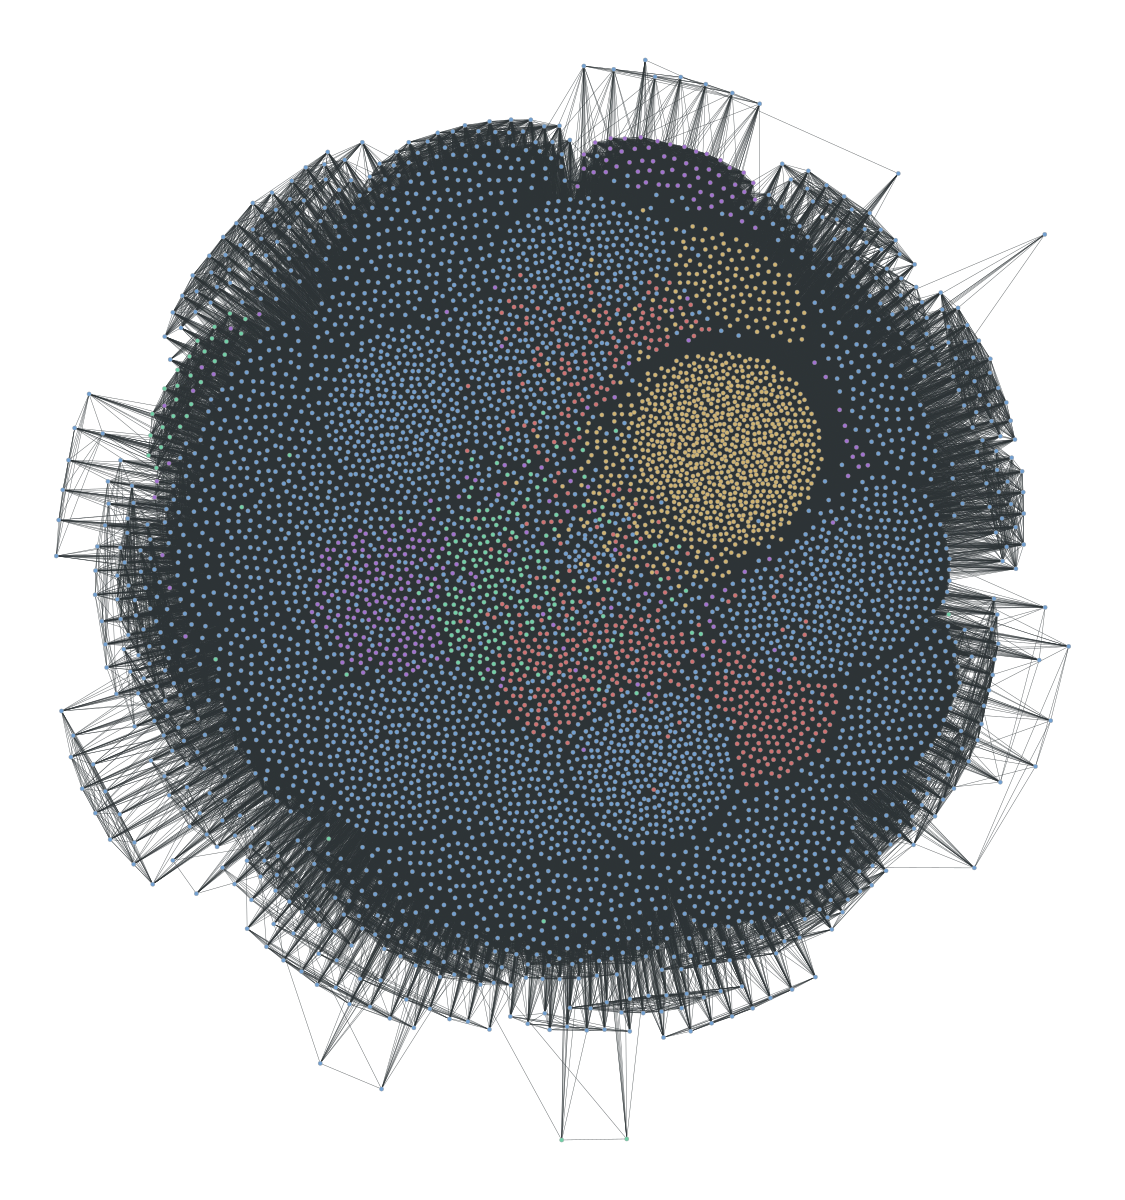

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f75017389d0, at 0x7f7501986f90>

In [20]:
biggest_n_communities = 5

communities = Counter(property_map_communities)
biggest_communities = communities.most_common(biggest_n_communities)
print(f"Biggest communities: {biggest_communities}")

community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
for i in range(1, biggest_n_communities):
    community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == biggest_communities[i][0], True, False))
print(f"len community_bool_filter: {len(community_bool_filter)}")
print(f"community_bool_filter: {community_bool_filter[:10]}")
print(f"property_map_communities: {property_map_communities[:10]}")

print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# graph_community_analyzer.graph.set_vertex_filter(filter_mask)

# color mapping for communities
color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7'}
# color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7', 5: '#cf720f', 6: '#72ca72', 7: '#cf7202', 8: '#72cf72', 9: '#0f720f'}
color_map_from_biggest_communities_indexes = {biggest_communities[i][0]: color_map[i] for i in range(biggest_n_communities)}

print(f"color_map_from_biggest_communities_indexes {color_map_from_biggest_communities_indexes}")

vcolor = graph_community_analyzer.graph.new_vp("string") 

print(f"vcolor type: {type(vcolor)}")
print(f"filter_mask type: {type(filter_mask)}")

for v in graph_community_analyzer.graph.vertices():
    if graph_community_analyzer.graph.vertex_index[v] in np.where(community_bool_filter)[0]:
        vcolor[v] = color_map_from_biggest_communities_indexes[property_map_communities[graph_community_analyzer.graph.vertex_index[v]]]

# fill all vcolor values with black if not in filter_mask
for v in graph_community_analyzer.graph.vertices():
    if vcolor[v] == "":
        vcolor[v] = '#000000'

u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
graph_draw(u, vertex_fill_color=vcolor)






## Visualize smallest 5 communities

Smallest communities: [(np.int32(690), 13), (np.int32(7684), 21), (np.int32(59), 22), (np.int32(3067), 22), (np.int32(736), 69), (np.int32(2429), 74), (np.int32(5989), 100), (np.int32(3455), 108)]
len community_bool_filter: 8013
community_bool_filter: [False False False False False False False False False False]
property_map_communities: [   0    0    0    0    0    0    0 6433    0    0]
all values with True in community_bool_filter: [2429 2429 2429 2429 2429 2429 2429 7684 7684 3067 3455 3455 2429 2429
 2429  736 3455  736 2429 2429 2429 2429 2429  736 2429 3455 7684  736
  736 7684 3455 2429  736 7684 5989 2429 2429 2429 2429  736 3455 2429
 5989 2429 2429 3455  736  736  736 2429 2429 3455 3455 3455  736 2429
 3455 2429 3455 3455 3455 3455 3455  736 2429 2429 2429 2429 2429 2429
  736 3455 3455 2429 2429 3455 7684 2429 2429  736   59 2429  736 3455
 3455 3455 7684  736  736   59 3455 3455  736  736  736 2429 2429 2429
 5989  736 3455 3455 3455   59  736 2429 2429 2429 2429 2429 242

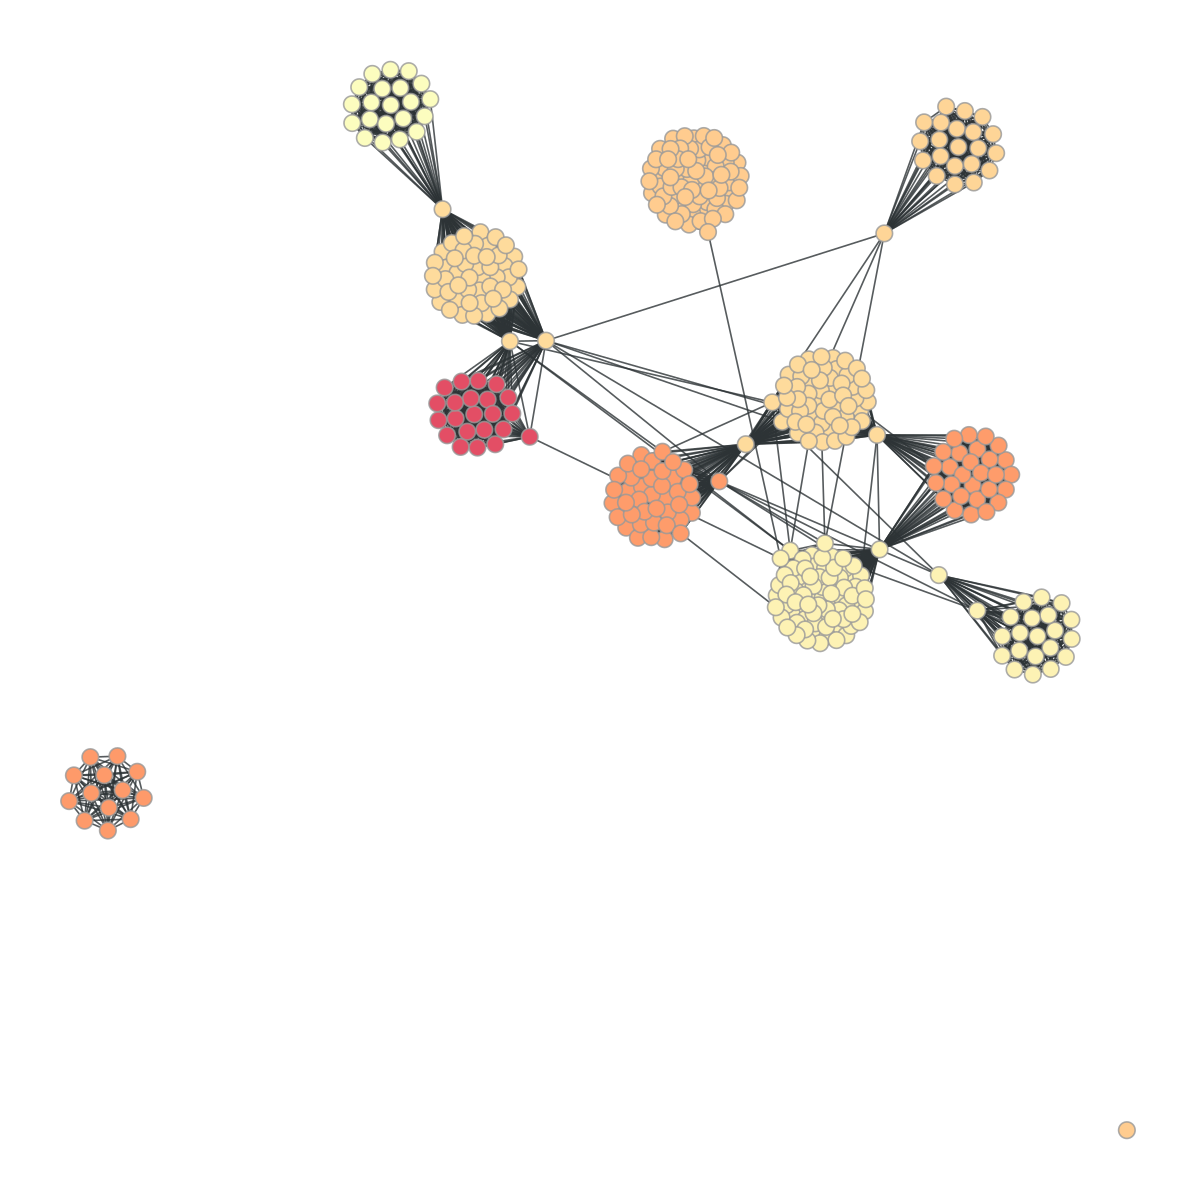

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f22d9dec9d0, at 0x7f233b53c390>

In [15]:
# visualize smallest 5 communities
n_smallest_communities = 8

smallest_communities = communities.most_common()[:-(n_smallest_communities+1):-1]
print(f"Smallest communities: {smallest_communities}")

community_bool_filter = np.where(property_map_communities == smallest_communities[0][0], True, False)
# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
for i in range(1, n_smallest_communities):
    community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == smallest_communities[i][0], True, False))
print(f"len community_bool_filter: {len(community_bool_filter)}")
print(f"community_bool_filter: {community_bool_filter[:10]}")
print(f"property_map_communities: {property_map_communities[:10]}")

print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# graph_community_analyzer.graph.set_vertex_filter(filter_mask)

u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
graph_draw(u, vertex_fill_color=prop_to_size(graph_community_analyzer.communities['communities_modularity'], 0,1, power=.1))


## Get statistics of communities

### Init DB to query contributor information

In [8]:
from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db
from datetime import datetime

db_category_names = ['Amiga CD32 games', 'Machine learning', 'Game Boy games', 'Artificial intelligence']

category_name  = db_category_names[0]
db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)

Database initialized: wikipedia.db


In [9]:
def get_edit_stats_for_category(graph_community_analyzer, category_name):
    main_category_id = db_manager.get_main_category_by_name(category_name)

    # get all vertex properties
    vertex_properties = graph_community_analyzer.graph.vertex_properties
    #get id property
    id_property = vertex_properties['id']

    # construct a dict with the community as key and the nodes, stats as values
    community_stats = {'max': {}, 'min': {}, 'avg': {}, 'total': {}}
    community_nodes = {}
    community_nodes_nb_edits = {}
    nodes_oldest_edit = {}
    nodes_newest_edit = {}
    community_oldest_edit = {}
    community_newest_edit = {}

    for v in graph_community_analyzer.graph.vertices():
        community = property_map_communities[graph_community_analyzer.graph.vertex_index[v]]
        if community not in community_nodes:
            community_nodes[community] = []
            community_nodes_nb_edits[community] = []
        community_nodes[community].append(v)
        community_nodes_nb_edits[community].append(db_manager.get_number_of_revisions_per_contributor(id_property[v], main_category_id))
        node_edit_dates = db_manager.get_oldest_and_newest_revision_per_contributor_and_main_category(id_property[v], main_category_id)

        #parse date string as datetime
        node_edit_dates['oldest_revision'] = datetime.strptime(node_edit_dates['oldest_revision'], '%Y-%m-%dT%H:%M:%SZ')
        node_edit_dates['newest_revision'] = datetime.strptime(node_edit_dates['newest_revision'], '%Y-%m-%dT%H:%M:%SZ')

        nodes_oldest_edit[int(v)] = node_edit_dates['oldest_revision']
        nodes_newest_edit[int(v)] = node_edit_dates['newest_revision']
        
        if community not in community_oldest_edit:
            community_oldest_edit[community] = node_edit_dates['oldest_revision']
            community_newest_edit[community] = node_edit_dates['newest_revision']

        if community_oldest_edit[community] > node_edit_dates['oldest_revision']:
            community_oldest_edit[community] = node_edit_dates['oldest_revision']

        if community_newest_edit[community] < node_edit_dates['newest_revision']:
            community_newest_edit[community] = node_edit_dates['newest_revision']

    for community in community_nodes_nb_edits.keys():
        community_stats['max'][community] = np.max(community_nodes_nb_edits[community])
        community_stats['min'][community] = np.min(community_nodes_nb_edits[community])
        community_stats['avg'][community] = np.mean(community_nodes_nb_edits[community])
        community_stats['total'][community] = np.sum(community_nodes_nb_edits[community])

    print(f"community_nodes: {community_nodes}")
    print(f"len community_nodes: {len(community_nodes.keys())}")

    #Total number of edits in category
    print(f"Total number of edits in category {category_name}: {db_manager.get_total_number_of_revisions_per_main_category(main_category_id)}")
    #Average number of edits per contributor
    print(f"Average edits of category {category_name}: {np.mean([np.mean(community_nodes_nb_edits[community]) for community in community_nodes_nb_edits.keys()])}")

    return community_stats, nodes_oldest_edit, nodes_newest_edit, community_nodes_nb_edits, community_oldest_edit, community_newest_edit

community_stats, nodes_oldest_edit, nodes_newest_edit, community_nodes_nb_edits, community_oldest_edit, community_newest_edit = get_edit_stats_for_category(graph_community_analyzer, category_name)


community_nodes: {np.int32(6307): [<Vertex object with index '0' at 0x7f7512554ac0>, <Vertex object with index '1' at 0x7f75202b94c0>, <Vertex object with index '3' at 0x7f75a8e222c0>, <Vertex object with index '4' at 0x7f75124e34c0>, <Vertex object with index '5' at 0x7f75124e3940>, <Vertex object with index '6' at 0x7f7512554d40>, <Vertex object with index '8' at 0x7f7512554e40>, <Vertex object with index '9' at 0x7f7512555040>, <Vertex object with index '10' at 0x7f7512554f40>, <Vertex object with index '11' at 0x7f7512555240>, <Vertex object with index '12' at 0x7f75125550c0>, <Vertex object with index '13' at 0x7f7512554dc0>, <Vertex object with index '14' at 0x7f7512555440>, <Vertex object with index '18' at 0x7f75125556c0>, <Vertex object with index '20' at 0x7f75125557c0>, <Vertex object with index '21' at 0x7f7512555840>, <Vertex object with index '24' at 0x7f75125559c0>, <Vertex object with index '26' at 0x7f7512554ec0>, <Vertex object with index '27' at 0x7f7512555340>, <Ver

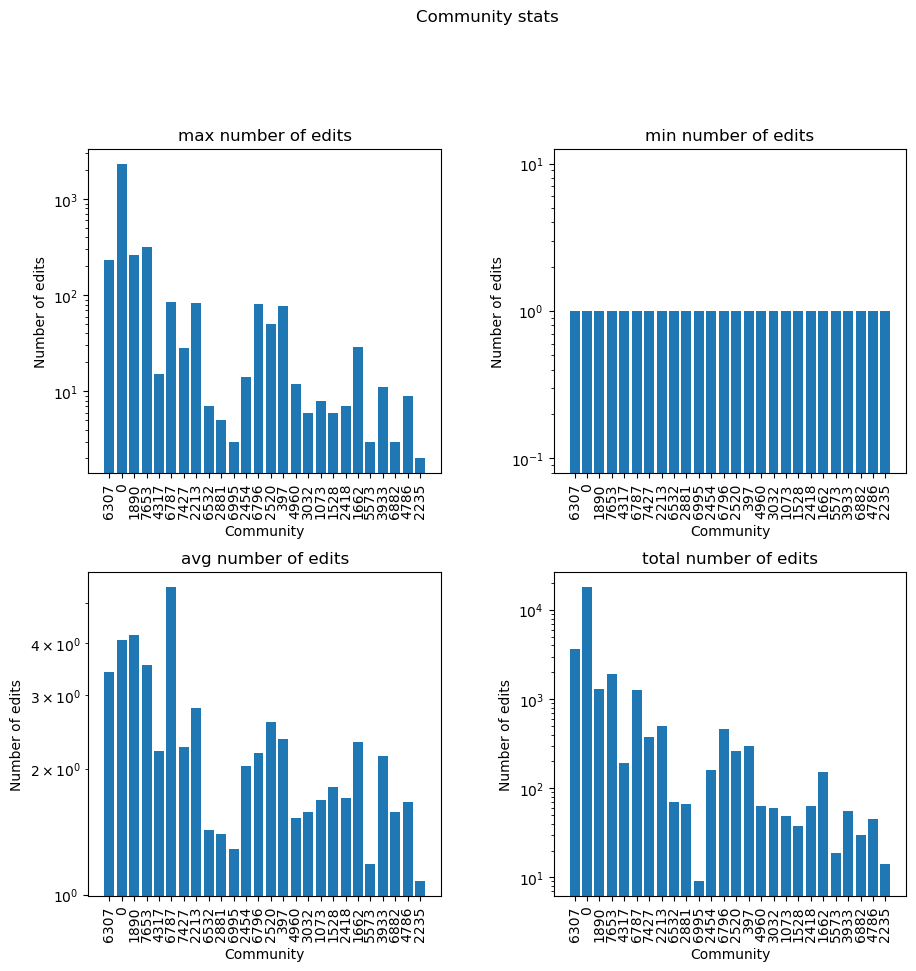

In [10]:
#plot distribution of stats over communities

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Community stats')
fig.tight_layout(pad=5.0)

for i, stat in enumerate(community_stats.keys()):
    ax = axs[i//2, i%2]
    x_label_strings = [f'{community}' for community in community_stats[stat].keys()]
    x = np.arange(len(community_stats[stat].keys()))
    y = list(community_stats[stat].values())
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_yscale('log')
    ax.set_title(f'{stat} number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel('Community')
    
plt.show()

26 26 26
<class 'datetime.datetime'>
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
dict_values([datetime.datetime(2002, 8, 5, 2, 35, 22), datetime.datetime(2001, 9, 29, 16, 40, 6), datetime.datetime(2003, 5, 10, 17, 30, 19), datetime.datetime(2003, 9, 4, 15, 7, 46), datetime.datetime(2003, 12, 11, 22, 14, 16), datetime.datetime(2003, 10, 21, 2, 20, 56), datetime.datetime(2004, 7, 25, 21, 57, 4), datetime.datetime(2004, 6, 28, 0, 33, 32), datetime.datetime(2005, 4, 5, 18, 19, 26), datetime.datetime(2005, 6, 6, 7, 8, 42), datetime.datetime(2005, 3, 19, 9, 57, 17), datetime.datetime(2005, 7, 31, 4, 29, 46), datetime.datetime(2005, 8, 21, 22, 12, 59), datetime.datetime(2005, 10, 17, 13, 12, 45), datetime.datetime(2006, 1, 3, 0, 45, 2), datetime.datetime(2006, 1, 18, 12, 54, 28), datetime.datetime(2006, 1, 23, 22, 0, 6), datetime.datetime(2006, 4, 3, 3, 58, 47), datetime.datetime(2006, 4, 6, 20, 30, 9), datetime.datetime(2006, 8, 8, 9, 54, 56), datetime.da

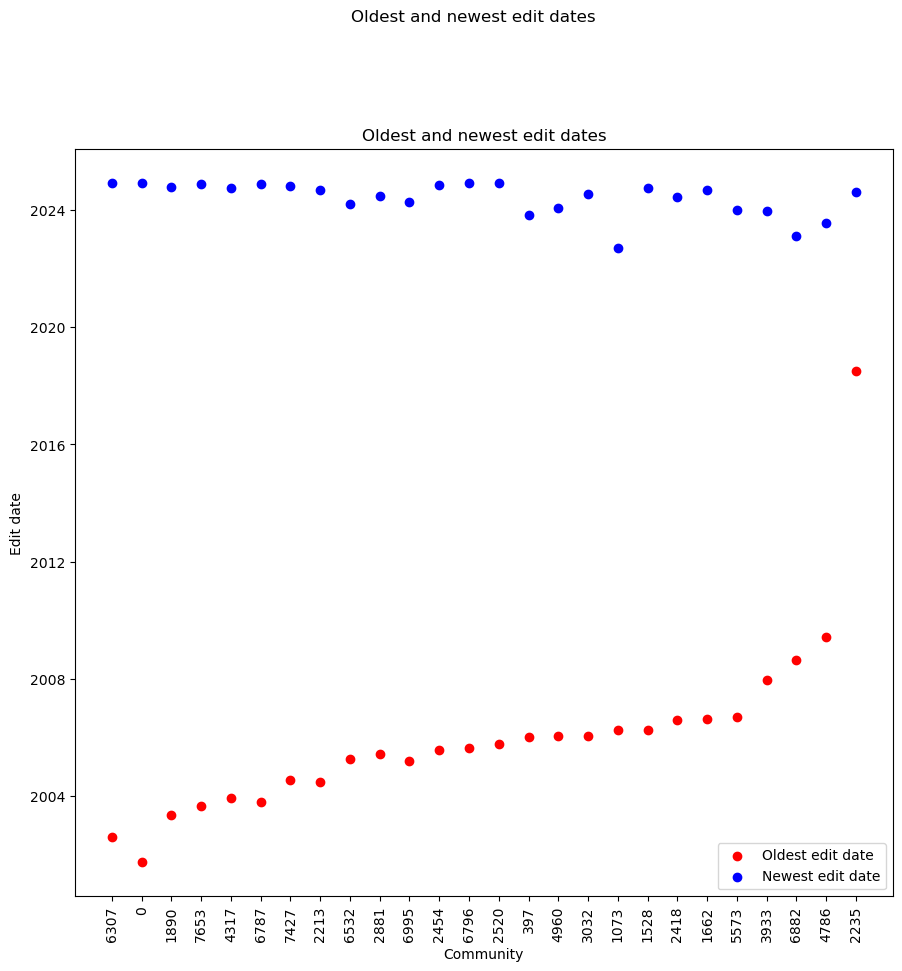

In [11]:
# plot oldest and newest edit dates as scatter plot with the oldest and newest edit dates as different colors for each community in the y-axis

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig.suptitle('Oldest and newest edit dates')
fig.tight_layout(pad=5.0)

x = np.arange(len(community_oldest_edit.keys()))
x_label_strings = [f'{community}' for community in community_oldest_edit.keys()]
y1 = community_oldest_edit.values()
y2 = community_newest_edit.values()
print(len(x), len(y1), len(y2))

print(type(list(y1)[0]))

print(x)
print(y1)
ax.scatter(x, y1, color='r', label='Oldest edit date')
ax.scatter(x, y2, color='b', label='Newest edit date')
ax.set_xticks(x)
ax.set_xticklabels(x_label_strings, rotation=90)
ax.set_title('Oldest and newest edit dates')
ax.set_ylabel('Edit date')
ax.set_xlabel('Community')
ax.legend()


## Analyze graph properties and plot them per community

In [16]:

# get closeness centrality for each community
# closn = closeness(graph_community_analyzer.graph)
# eigenv = eigenvector(graph_community_analyzer.graph)[1].get_array()

# print(f"len closn: {len(closn)}")
# print(f"len eigenv: {len(eigenv)}")

centrality_analyzer = CentralityAnalyzer(graph_community_analyzer.graph)
centrality_analyzer.calculate_centralities()

closn = centrality_analyzer.get_closeness_centrality()
eigenv = centrality_analyzer.get_eigenvector_centrality()
betweenness = centrality_analyzer.get_betweenness_centrality()
degrees = centrality_analyzer.get_degrees()




Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.11 seconds.

Calculating closeness...
Closeness centrality calculated in 39.06 seconds.

Calculating betweenness...
Betweenness centrality calculated in 47.19 seconds.



In [18]:
community_closeness = {}
community_eigenvector = {}
community_betweenness = {}
community_degrees = {}

# get closeness centrality for each community
for v in graph_community_analyzer.graph.vertices():
    community = property_map_communities[graph_community_analyzer.graph.vertex_index[v]]

    if community not in community_closeness:
        community_closeness[community] = []
    community_closeness[community].append(closn[graph_community_analyzer.graph.vertex_index[v]])

    # get eigenvector centrality for each community
    if community not in community_eigenvector:
        community_eigenvector[community] = []
    community_eigenvector[community].append(eigenv[graph_community_analyzer.graph.vertex_index[v]])

    # get betweenness centrality for each community
    if community not in community_betweenness:
        community_betweenness[community] = []
    community_betweenness[community].append(betweenness[graph_community_analyzer.graph.vertex_index[v]])

    # get degrees for each community
    if community not in community_degrees:
        community_degrees[community] = []
    community_degrees[community].append(degrees[graph_community_analyzer.graph.vertex_index[v]])


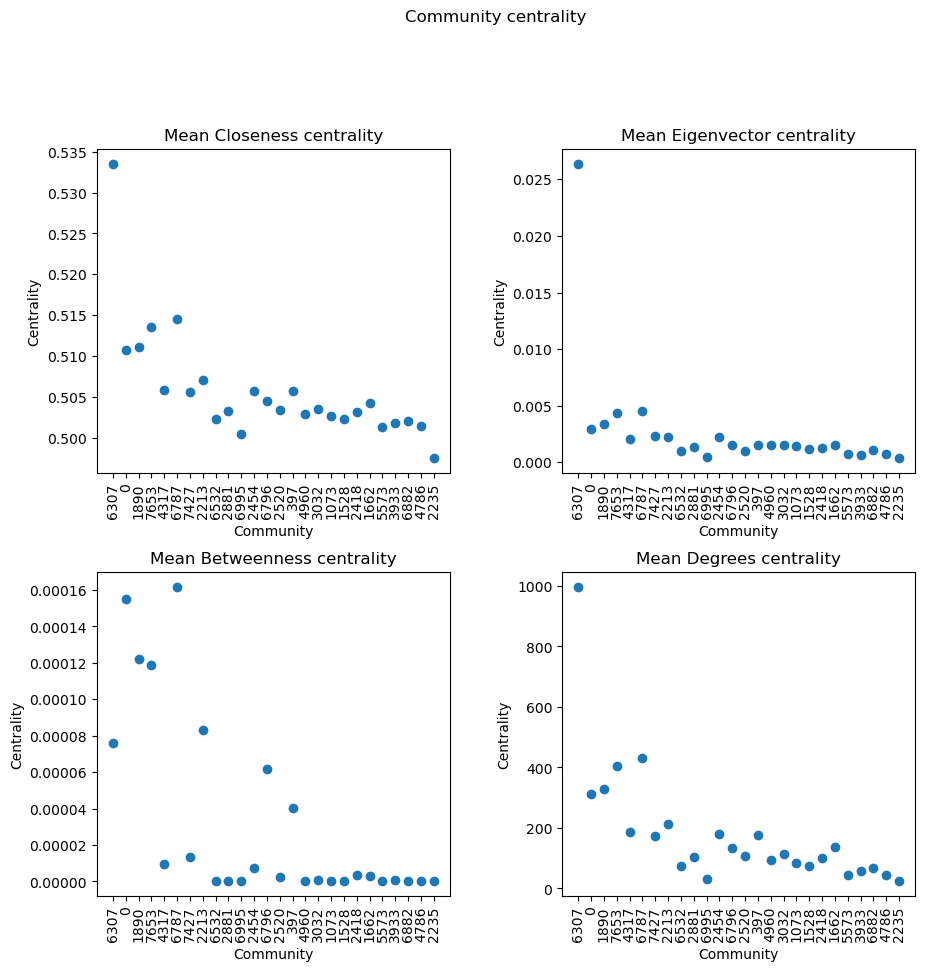

In [19]:
#plot distribution of closeness and eigenvector centrality over communities

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Community centrality')
fig.tight_layout(pad=5.0)

for i, centrality in enumerate([community_closeness, community_eigenvector]):
    ax = axs[0][i]
    chart_title = 'Closeness' if i == 0 else 'Eigenvector'
    x_label_strings = [f'{community}' for community in centrality.keys()]
    x = np.arange(len(centrality.keys()))
    y = [np.mean(centrality[community]) for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_title(f'Mean {chart_title} centrality')
    ax.set_ylabel('Centrality')
    ax.set_xlabel('Community')

for i, centrality in enumerate([community_betweenness, community_degrees]):
    ax = axs[1][i]
    chart_title = 'Betweenness' if i == 0 else 'Degrees'
    x_label_strings = [f'{community}' for community in centrality.keys()]
    x = np.arange(len(centrality.keys()))
    y = [np.mean(centrality[community]) for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_title(f'Mean {chart_title} centrality')
    ax.set_ylabel('Centrality')
    ax.set_xlabel('Community')

plt.show()


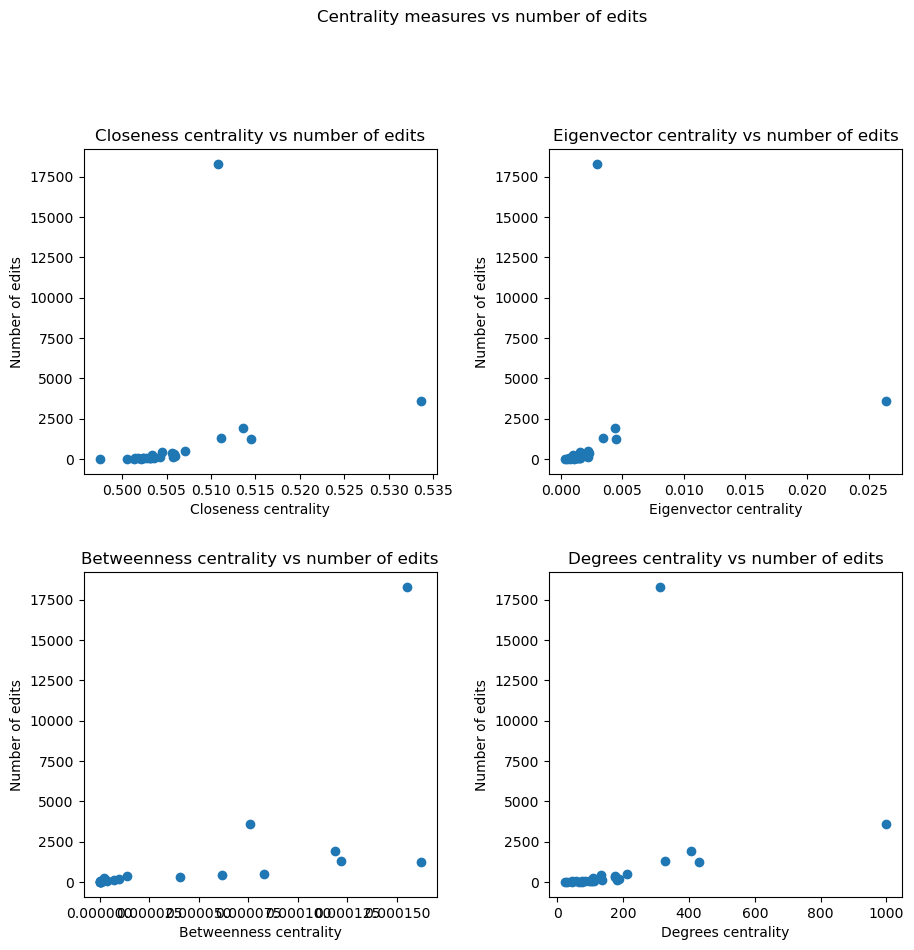

In [26]:
# plot centrality measures against number of edits for each community

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Centrality measures vs number of edits')
fig.tight_layout(pad=5.0)

for i, centrality in enumerate([community_closeness, community_eigenvector]):
    ax = axs[0][i]
    chart_title = 'Closeness' if i == 0 else 'Eigenvector'
    x = [np.mean(centrality[community]) for community in centrality.keys()]
    y = [np.sum(community_nodes_nb_edits[community]) for community in centrality.keys()]
    labels = [f'{community}' for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_title(f'{chart_title} centrality vs number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel(f'{chart_title} centrality')

for i, centrality in enumerate([community_betweenness, community_degrees]):
    ax = axs[1][i]
    chart_title = 'Betweenness' if i == 0 else 'Degrees'
    x = [np.mean(centrality[community]) for community in centrality.keys()]
    y = [np.sum(community_nodes_nb_edits[community]) for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_title(f'{chart_title} centrality vs number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel(f'{chart_title} centrality')